<a href="https://colab.research.google.com/github/edwin-19/waste_detection/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset

In [1]:
!wget https://conservancy.umn.edu/bitstream/handle/11299/214865/dataset.zip
!unzip dataset.zip

--2022-02-28 16:15:21--  https://conservancy.umn.edu/bitstream/handle/11299/214865/dataset.zip
Resolving conservancy.umn.edu (conservancy.umn.edu)... 128.101.122.105
Connecting to conservancy.umn.edu (conservancy.umn.edu)|128.101.122.105|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: 553029970 (527M) [application/zip]
Saving to: ‘dataset.zip.1’

dataset.zip.1       100%[===================>] 527.41M  42.1MB/s    in 13s     

2022-02-28 16:15:34 (41.8 MB/s) - ‘dataset.zip.1’ saved [553029970/553029970]

Archive:  dataset.zip
replace dataset/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [113]:
import json
from PIL import Image
import numpy as np
import cv2
from matplotlib import pyplot as plt
import glob
import json
from pprint import pprint
import os
import pandas as pd
import seaborn as sns

# Helper functions
- Some functions to help us generalize some situations

In [3]:
def read_json(json_path: str):
  with open(json_path, 'r') as json_file:
    data = json.loads(json_file.read())
  
  return data

In [121]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

# Parse Anotations Struct
- Contains images
- Contains annotations
  - Segmentation (multiple points)
  - BBox
  - Category
- Categories
  - General category of all the annotations

# Vis Image
- Lets parse and draw the image information to visualize
- We need to parse the bbox and seg data

In [15]:
root_img_path = 'dataset/instance_version/train/'

In [10]:
data = read_json('dataset/instance_version/instances_train_trashcan.json')

In [21]:
label_categories = data['categories']

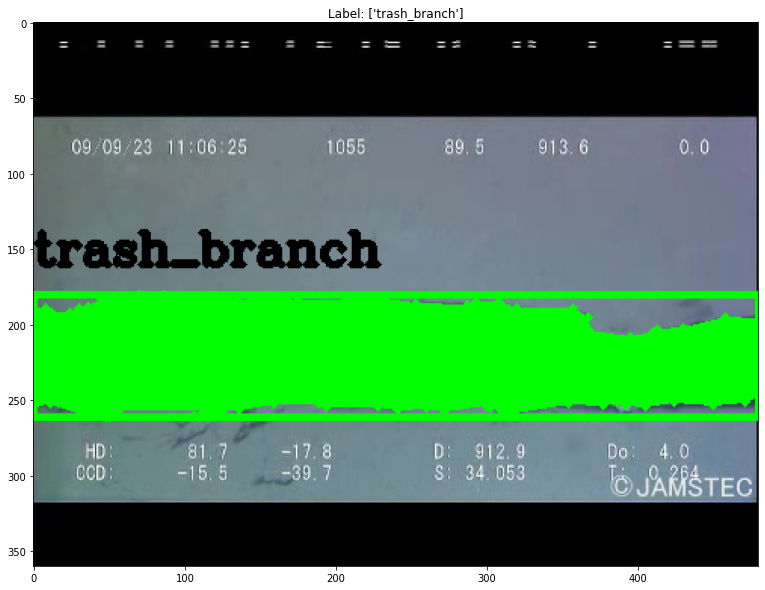

In [195]:
image_data = np.random.choice(data['images'])
img_path = os.path.join(root_img_path, image_data['file_name'])
annotation_datas = [d for d in data['annotations'] if d['image_id'] == image_data['id']]
category_data = [l['name'] for l in label_categories for annot in annotation_datas if l['id'] == annot['category_id']]
img_pil = Image.open(img_path)
img = np.array(img_pil)
img_copy = img.copy()

h, w = img.shape[:2]

for index, annot_data in enumerate(annotation_datas):
  bb = np.array(annot_data['bbox'], dtype=np.int64)
  xmin, ymin, xmax, ymax = bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3]
  cv2.rectangle(img_copy,(xmin, ymin), (xmax, ymax) , (0, 255, 0), 3)

  segs = np.array(annot_data['segmentation'])
  for seg in segs:
    seg = np.array(seg, dtype=np.int64).reshape(-1, 2)
    cv2.fillPoly(img_copy, pts=[seg.reshape(-1, 2)], color =(0,255,0))
    for s in seg:
      cv2.circle(img_copy, (s[0], s[1]), 1, (0, 255, 0), 3)

  cv2.putText(img_copy, category_data[index], (xmin, ymin - 20), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 3)
plt.figure(figsize=(15, 10))
plt.title('Label: {}'.format(category_data))
plt.imshow(img_copy)

# EDA & Data Vis
- Lets do a simple class count to make things a lot simpler to vis
- First things first make everything to a dataframe with various data for easier understanding

In [183]:
normed_data = []
for image in data['images']:
  image_id = image['id']
  image_annots = [d for d in data['annotations'] if image_id == d['image_id']]
  
  label_name = []
  for annot in image_annots:
    for label in label_categories:
      if label['id'] == annot['category_id']:
        label_name.append(label['name'])
        
  normed_data.append({
      'image_id': image_id,
      'image_height': image['height'],
      'image_width': image['width'],
      'label': label_name
  })

In [184]:
df = pd.DataFrame(normed_data)
df['label_count'] = df['label'].apply(lambda x: len(x))

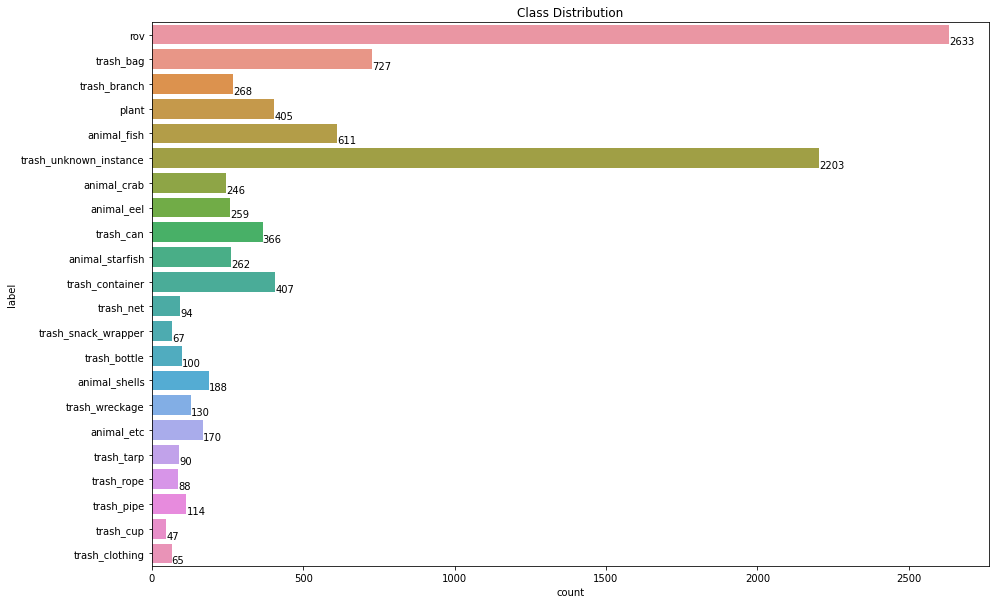

In [185]:
df_label = pd.DataFrame(np.concatenate(df['label'].tolist()), columns=['label'])
plt.figure(figsize=(15, 10))
plt.title('Class Distribution')
bar = sns.countplot(data=df_label, y='label')
show_values_on_bars(bar, h_v='h', space=0.2)

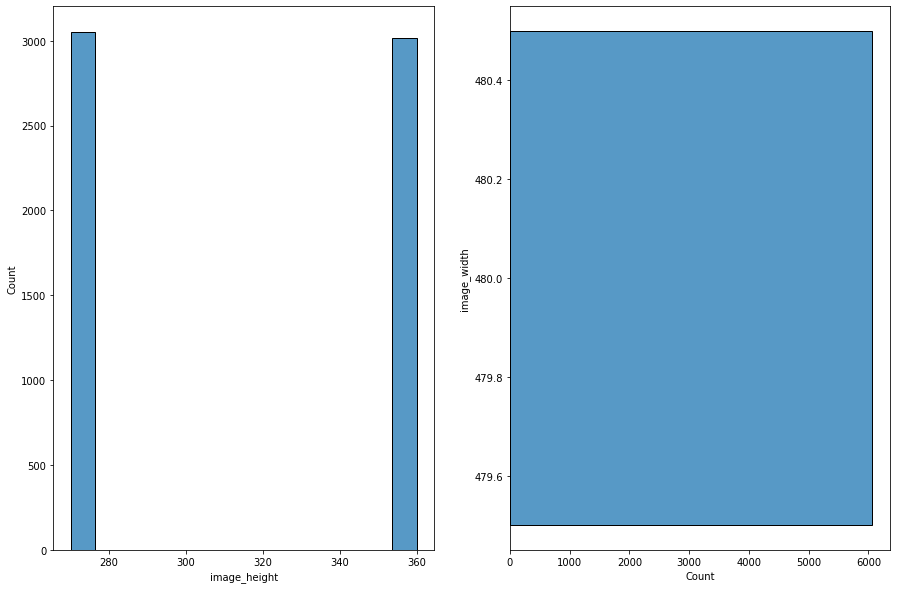

In [186]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='image_height')

plt.subplot(1, 2, 2)
sns.histplot(data=df, y='image_width')